In [24]:
import numpy as np
import tensorflow as tf
from sklearn import metrics
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import math

In [25]:
seizure_type = "combined"
model_type = "default"

model_path = f"model/tflite_models/{seizure_type}_2.tflite"
main_folder_path = "melspectrograms/"
path = main_folder_path + seizure_type + "/"

if seizure_type == "combined":
    path = main_folder_path + "absence" + "/"
    test_x_absence = np.load(f"{path}/test_absence_x.npy")
    test_y_absence = np.load(f"{path}/test_absence_y.npy")

    path = main_folder_path + "tonic-clonic" + "/"
    test_x_tonic_clonic = np.load(f"{path}/test_tonic-clonic_x.npy")
    test_y_tonic_clonic = np.load(f"{path}/test_tonic-clonic_y.npy")

    for i, v in enumerate(test_x_tonic_clonic):
        if test_y_tonic_clonic[i] == 1:
            test_y_tonic_clonic[i] = 2

    path = main_folder_path + "general" + "/"
    test_x_general = np.load(f"{path}/test_general_x.npy")
    test_y_general = np.load(f"{path}/test_general_y.npy")

    for i, v in enumerate(test_x_general):
        if test_y_general[i] == 1:
            test_y_general[i] = 3

    test_x = np.concatenate((test_x_absence, test_x_tonic_clonic, test_x_general))
    test_y = np.concatenate((test_y_absence, test_y_tonic_clonic, test_y_general))
else:
    test_x = np.load(f"{path}/test_{seizure_type}_x.npy")
    test_y = np.load(f"{path}/test_{seizure_type}_y.npy")

In [26]:
interpreter = tf.lite.Interpreter(model_path=model_path)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

input_shape = input_details[0]["shape"]

In [27]:
test_x = np.expand_dims(test_x, axis=1)
print(test_x.shape)

(1615, 1, 40, 26)


In [28]:
# Input size
print("Input Shape:", input_shape)

Input Shape: [ 1  1 40 26]


# Inference


In [29]:
tp, tn, fp, fn = 0, 0, 0, 0
comb_actual, comb_predicted = [], []

for i, v in enumerate(test_x):
    v = np.uint8(v)
    v = np.expand_dims(v, axis=0)
    interpreter.set_tensor(input_details[0]["index"], v)
    interpreter.invoke()

    output_data = interpreter.get_tensor(output_details[0]["index"])

    output_zeropoint = output_details[0]["quantization"][1]
    output_scale = output_details[0]["quantization"][0]

    output_data_0 = (output_data[0][0] - output_zeropoint) * output_scale
    output_data_1 = (output_data[0][1] - output_zeropoint) * output_scale
    output_data_2 = (output_data[0][2] - output_zeropoint) * output_scale
    output_data_3 = (output_data[0][3] - output_zeropoint) * output_scale

    output_data = [output_data_0, output_data_1, output_data_2, output_data_3]

    output_data = tf.nn.softmax(output_data).numpy()

    comb_actual.append(test_y[i])
    comb_predicted.append(output_data)

# Multi-Class Results


In [30]:
y_true = []
for i in test_y:
    y_true.append(i)
y_pred = []
for i in comb_predicted:
    max_value = max(i)
    for index, value in enumerate(i):
        if value == max_value:
            y_pred.append(index)
            break
y_true, y_pred = np.array(y_true), np.array(y_pred)

print(len(test_y), len(comb_predicted))
print(y_true.shape, y_pred.shape)

y_score = []
for i in comb_predicted:
    y_score.append(i)

1615 1615
(1615,) (1615,)


In [31]:
n_absz = 0
n_tcsz = 0
n_gnsz = 0
n_bckg = 0
for i in test_y:
    if i == 1:
        n_absz += 1
    elif i == 2:
        n_tcsz += 1
    elif i == 3:
        n_gnsz += 1
    else:
        n_bckg += 1


print("Absence Seizures:", n_absz)
print("Tonic-Clonic Seizures:", n_tcsz)
print("Generalized Seizures:", n_gnsz)
print("Background:", n_bckg)
print("Total:", n_absz + n_tcsz + n_gnsz + n_bckg)

Absence Seizures: 20
Tonic-Clonic Seizures: 159
Generalized Seizures: 136
Background: 1300
Total: 1615


In [32]:
labels = ["Background", "Absence", "Tonic-Clonic", "General"]
cm = metrics.confusion_matrix(y_true, y_pred)

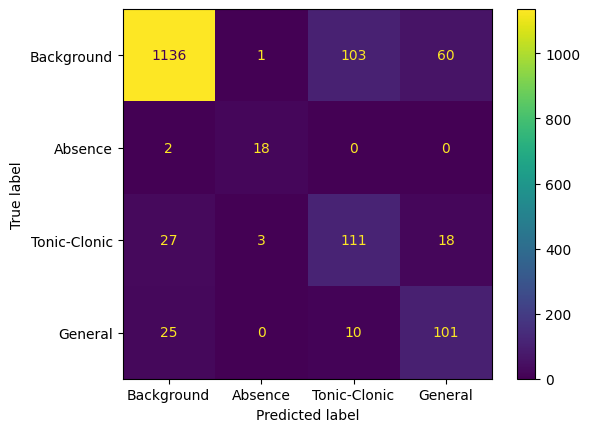

In [33]:
a = metrics.ConfusionMatrixDisplay(cm, display_labels=labels)
a.plot()
# a.figure_.savefig(f"results/pytorch_inference/default/combined/combined_cm.png")

In [40]:
TP = 18 + 46 + 81
FN = 2 + (103 + 5 + 5) + 55

total_s = TP + FN
# print(total_s)

TN = 1294
FP = 3 + 3
total_b = TN + FP
# print(total_b)

accuracy = ((TP + TN) / (total_s + total_b)) * 100
print(f"Accuracy: {accuracy}")

sensitivity = (TP / total_s) * 100
print(f"Sensitivity: {sensitivity} ({TP} / {total_s})")

specificity = (TN / total_b) * 100
print(f"Specificity: {specificity} ({TN} / {total_b})")

GMEAN = (math.sqrt(sensitivity / 100 * specificity / 100)) * 100
print(f"G-Mean: {GMEAN}")

Accuracy: 89.10216718266254
Sensitivity: 46.03174603174603 (145 / 315)
Specificity: 99.53846153846155 (1294 / 1300)
G-Mean: 67.68994889885191


In [41]:
auc_score = (
    metrics.roc_auc_score(
        y_true=y_true, y_score=y_score, average="macro", multi_class="ovo"
    )
) * 100
print(f"ROC AUC: {auc_score}")

ROC AUC: 93.4271236197672


In [98]:
def percentage_decrease(initial_value, final_value):
    print(initial_value, final_value)

    if final_value < initial_value:
        print("-")
        return round(((initial_value - final_value) / initial_value) * 100, 10)
    else:
        print("+")
        return round(((final_value - initial_value) / initial_value) * 100, 10)

In [99]:
percentage_decrease(47, 23)

47 23
-


51.0638297872